In [8]:
# Importing necessary libraries
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt
from pomegranate import *

In [9]:
# Reading data
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [10]:
# Changing data into discrete variables before sending into the model

import numpy as np
bayes_data = data.copy()
bayes_data['ageC'] = np.where(data['age'] >=60,1,0)
bayes_data['oldpeakC'] = np.where(data['oldpeak'] <= 1 ,1 ,0)
bayes_data['thalachC'] = np.where(data['thalach'] >= 150 ,1 ,0)
bayes_data['trestbpsC'] = np.where(data['trestbps'] >= 120 ,1 ,0)

bayes_data.drop("age", axis =1 , inplace = True)
bayes_data.drop("trestbps", axis = 1, inplace = True)
bayes_data.drop("chol", axis = 1, inplace = True)
bayes_data.drop("oldpeak", axis = 1,inplace = True)
bayes_data.drop("thalach", axis = 1,inplace = True)
bayes_data.drop("fbs", axis = 1,inplace = True)
bayes_data.drop("restecg", axis = 1,inplace = True)


bayes_data.head(5)

,sex,cp,exang,slope,ca,thal,target,ageC,oldpeakC,thalachC,trestbpsC
0,1,3,0,0,0,1,1,1,0,1,1
1,1,2,0,0,0,2,1,0,0,1,1
2,0,1,0,2,0,2,1,0,0,1,1
3,1,1,0,2,0,2,1,0,1,1,1
4,0,0,1,2,0,2,1,0,1,1,1


In [11]:
# Creating Bayesian Model
model = BayesianModel([('ageC','trestbpsC'),('cp','exang'),('slope','oldpeakC'),('exang','thalachC'),
                       ('slope','thalachC'),('ca','ageC'),('thal','ca'),('thal','target'),('target','cp'),
                       ('sex','thal'),('target','oldpeakC'),('target','slope'),('trestbpsC','target')])

D:\Abhi\py_env\tf\lib\site-packages\pgmpy\models\BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


In [12]:
# Function to draw the graph of Bayesian nodes
import pygraphviz
import tempfile
import matplotlib.pyplot as plt
import matplotlib.image as matimg

def plot(model):
	G = pygraphviz.AGraph(directed=True)

	for state in model.states:
		G.add_node(state.name, color='red')

	for parent, child in model.edges:
		G.add_edge(parent.name, child.name)

	with tempfile.NamedTemporaryFile() as tf:
		G.draw(tf, format='png', prog='dot')
		img = matimg.imread(tf)
		plt.imshow(img)
		plt.axis('off')
		plt.show()

In [13]:
# Visual Representation Of Bayesian Network
s1 = Node(model.get_cpds('ageC'), name = "Age")
s2 = Node(model.get_cpds('trestbpsC'), name = "Resting Blood Sugar")
s3 = Node(model.get_cpds('cp'), name = "Chest Pain Type")
s4 = Node(model.get_cpds('exang'), name = "Exercise Induced Angina")
s5 = Node(model.get_cpds('slope'), name = "Slope of Peak Exercise ST Segment")
s6 = Node(model.get_cpds('oldpeakC'), name = "ST depression induced by exercise relative to rest")
s7 = Node(model.get_cpds('thalachC'), name = "Maximum Heart rate Achieved")
s8 = Node(model.get_cpds('ca'), name = "Number of major vessels colored by fluoroscopy")
s9 = Node(model.get_cpds('sex'), name = "Sex")
s10= Node(model.get_cpds('target'), name = "Heart Disease")
s11= Node(model.get_cpds('thal'), name = "Defect Type")


network = BayesianNetwork()
network.add_states(s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11)
network.add_transition(s1,s2)
network.add_transition(s3,s4)
network.add_transition(s5,s6)
network.add_transition(s4,s7)
network.add_transition(s5,s7)
network.add_transition(s8,s1)
network.add_transition(s11,s8)
network.add_transition(s11,s10)
network.add_transition(s10,s3)
network.add_transition(s9,s11)
network.add_transition(s10,s6)
network.add_transition(s10,s5)
network.add_transition(s2,s10)



plot(network)

ValueError: Node not present in the Directed Graph

In [7]:
# Calculating accuracy for Bayesian Model
predictors = bayes_data.drop("target",axis=1)
target = bayes_data["target"]


X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)
bayesian_train = X_train
bayesian_train['target'] = Y_train
train_data = bayesian_train
model.fit(train_data,estimator=MaximumLikelihoodEstimator)
test_data = X_test
#print(X_test)
y_pred = model.predict(test_data)


score_bn = accuracy_score(y_pred, Y_test)
score_bn *= 100
print("The accuracy score achieved using Bayesian Network model is: "+str(score_bn)+" %")


     age  sex  cp  trestbps  thalach  exang  oldpeak  slope  ca  thal
225   70    1   0       145      125      1      2.6      0   0     3
152   64    1   3       170      155      0      0.6      1   0     3
228   59    1   3       170      159      0      0.2      1   0     3
201   60    1   0       125      141      1      2.8      1   1     3
52    62    1   2       130      146      0      1.8      1   3     3
..   ...  ...  ..       ...      ...    ...      ...    ...  ..   ...
146   44    0   2       118      149      0      0.3      1   1     2
302   57    0   1       130      174      0      0.0      1   1     2
26    59    1   2       150      157      0      1.6      2   0     2
108   50    0   1       120      162      0      1.1      2   0     2
89    58    0   0       100      122      0      1.0      1   0     2

[61 rows x 10 columns]


D:\Abhi\py_env\tf\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


NameError: name 'y_pred' is not defined

In [8]:
model.get_independencies()

(ca ⟂ thalachC, exang, oldpeakC, slope, cp | target)
(ca ⟂ exang | cp)
(ca ⟂ trestbpsC | ageC)
(ca ⟂ sex | thal)
(ca ⟂ thalachC, oldpeakC, cp, slope | target, exang)
(ca ⟂ exang, thalachC, slope, cp | target, oldpeakC)
(ca ⟂ exang, oldpeakC, cp, slope | target, thalachC)
(ca ⟂ exang, thalachC, oldpeakC, slope, cp | sex, target)
(ca ⟂ exang, thalachC, oldpeakC, slope | target, cp)
(ca ⟂ exang, thalachC, oldpeakC, slope, cp | target, ageC)
(ca ⟂ exang, thalachC, oldpeakC, slope, cp | target, trestbpsC)
(ca ⟂ exang, thalachC, oldpeakC, cp | target, slope)
(ca ⟂ exang, thalachC, oldpeakC, sex, slope, cp | target, thal)
(ca ⟂ thalachC | exang, slope)
(ca ⟂ sex | exang, thal)
(ca ⟂ exang | oldpeakC, cp)
(ca ⟂ sex | oldpeakC, thal)
(ca ⟂ sex | thalachC, thal)
(ca ⟂ exang | sex, cp)
(ca ⟂ trestbpsC | sex, ageC)
(ca ⟂ exang | cp, ageC)
(ca ⟂ exang | cp, trestbpsC)
(ca ⟂ exang, thalachC | slope, cp)
(ca ⟂ sex, exang | thal, cp)
(ca ⟂ target, thalachC, exang, oldpeakC, sex, trestbpsC, slope, cp |

In [9]:
# Splitting Data into Train and Test for other classifiers
predictors = data.drop("target",axis=1)
target = data["target"]
X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)


In [10]:
# Random Forest Classifier

max_accuracy = 0
for x in range(2000):
    rf = RandomForestClassifier(random_state=x)
    rf.fit(X_train,Y_train)
    Y_pred_rf = rf.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_rf,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        

rf = RandomForestClassifier(random_state=best_x)
rf.fit(X_train,Y_train)
Y_pred_rf = rf.predict(X_test)

score_rf = round(accuracy_score(Y_pred_rf,Y_test)*100,2)

print("The accuracy score achieved using Decision Tree is: "+str(score_rf)+" %")

KeyboardInterrupt: 

In [ ]:
# Neural Networks
model = Sequential()
model.add(Dense(11,activation='relu',input_dim=13))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train,Y_train,epochs=300)


Y_pred_nn = model.predict(X_test)
rounded = [round(x[0]) for x in Y_pred_nn]

Y_pred_nn = rounded

score_nn = round(accuracy_score(Y_pred_nn,Y_test)*100,2)

print("The accuracy score achieved using Neural Network is: "+str(score_nn)+" %")

Epoch 1/300
8/8 [==============================] - 1s 2ms/step - loss: 17.9548 - accuracy: 0.4446
Epoch 2/300
8/8 [==============================] - 0s 2ms/step - loss: 11.7090 - accuracy: 0.4943
Epoch 3/300
8/8 [==============================] - 0s 3ms/step - loss: 7.2101 - accuracy: 0.4997
Epoch 4/300
8/8 [==============================] - 0s 2ms/step - loss: 4.1775 - accuracy: 0.5510
Epoch 5/300
8/8 [==============================] - 0s 2ms/step - loss: 3.1493 - accuracy: 0.5851
Epoch 6/300
8/8 [==============================] - 0s 2ms/step - loss: 2.9813 - accuracy: 0.6058
Epoch 7/300
8/8 [==============================] - 0s 2ms/step - loss: 2.4104 - accuracy: 0.6281
Epoch 8/300
8/8 [==============================] - 0s 1ms/step - loss: 2.2621 - accuracy: 0.6335
Epoch 9/300
8/8 [==============================] - 0s 2ms/step - loss: 2.0057 - accuracy: 0.6343
Epoch 10/300
8/8 [==============================] - 0s 2ms/step - loss: 2.3444 - accuracy: 0.5936
Epoch 11/300
8/8 [=========

D:\Abhi\py_env\tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Algorithms', ylabel='Accuracy score'>

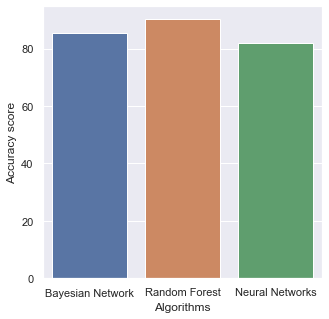

In [ ]:
# Comparison Between Different Classifiers
scores = [score_bn, score_rf, score_nn]
algorithms = ['Bayesian Network','Random Forest','Neural Networks']
sns.set(rc={'figure.figsize':(5,5)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(algorithms,scores)

In [ ]:
print(model.get_cpds('target'))

+-----------+--------------+-----+--------------------+
| thal      | thal(0)      | ... | thal(3)            |
+-----------+--------------+-----+--------------------+
| trestbpsC | trestbpsC(0) | ... | trestbpsC(1)       |
+-----------+--------------+-----+--------------------+
| target(0) | 0.5          | ... | 0.8108108108108109 |
+-----------+--------------+-----+--------------------+
| target(1) | 0.5          | ... | 0.1891891891891892 |
+-----------+--------------+-----+--------------------+


In [ ]:
# Example (Finding marginal probabilities)
infer = VariableElimination(model)
print(infer.query(['target'], evidence= {'sex' : 0}))

Eliminating: trestbpsC: 100%|██████████| 4/4 [00:00<00:00, 154.25it/s]

+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.3090 |
+-----------+---------------+
| target(1) |        0.6910 |
+-----------+---------------+
